In [29]:
include("isokann.jl")

sigma_to_beta (generic function with 1 method)

In [187]:
m = NN.Triplewell(20)

Main.NN.Langevin
  potential: triplewell (function of type typeof(Main.NN.triplewell))
  boundary: Main.NN.RadialCrisp{Vector{Float64}}
  box: Array{Float64}((2, 2)) [-3.0 3.0; -2.0 2.0]
  beta: Int64 20


In [188]:
x0 = NN.randuniform(m)(1000)
trajs = eulermarujamatrajectories(x0, m.potential, beta_to_sigma(m.beta), 0.01, 20, branches = 20);
size(trajs)

(2, 21, 20, 1000)

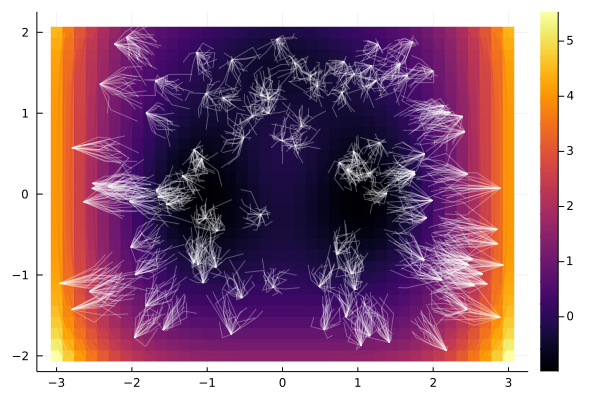

In [189]:
function plottrajs(process, trajs)
    NN.plot(process.potential, process.box)
    
    dim, step, branch, sample = size(trajs)
    tt = reshape(trajs, dim, step, branch*sample )
    plot!(tt[1, :, :], tt[2, :, :], color="white", legend=false, alpha=0.3)
end

plottrajs(m, trajs[:, 1:10:end, :, 1:10:end])

In [190]:
# given complete trajectories, stack the endpoints on the startpoint
#transform from format (dim, time, branch, sample) -> (dim, start+ends, sample)

function accumulatetrajs(trajs)
    dim, step, branch, sample = size(trajs)
    data = zeros(dim, 1+branch, sample)
    data[:, 1, :] = trajs[:, 1, 1, :]
    data[:, 2:end, :] = trajs[:, end, :, :]
    data
end

accumulatetrajs (generic function with 1 method)

In [191]:
data = accumulatetrajs(trajs)
nn, ls = isokann(model=mlp([5,5,5]), data=data, iter=10, poweriter=1000)

(Chain(Dense(2, 5, σ), Dense(5, 5, σ), Dense(5, 5, σ), Dense(5, 1), #204), [0.4130670865962613, 0.4130670865962613, 0.0761677188919578, 0.11676314577137274, 0.13249570377076014, 0.09354675834432445, 0.07225031238738701, 0.07225179674475347, 0.07360637328467014, 0.07179979674877378  …  0.0003890187765224719, 0.0003889409869726974, 0.0003888632948418037, 0.0003887856824000254, 0.0003887081313818206, 0.0003886306493152194, 0.0003885532506858281, 0.00038847592641759704, 0.0003883986638798995, 0.0003883214845006413])

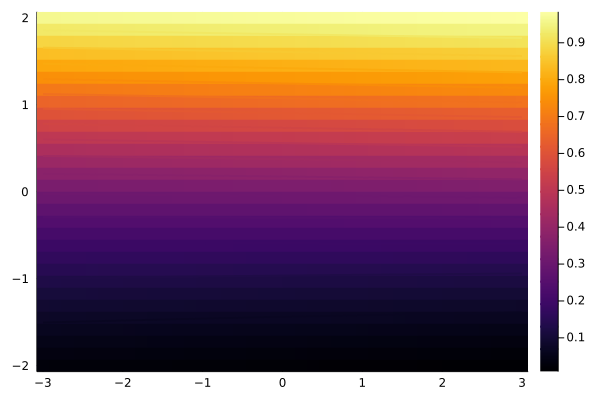

In [192]:
NN.plot(training, m.box)

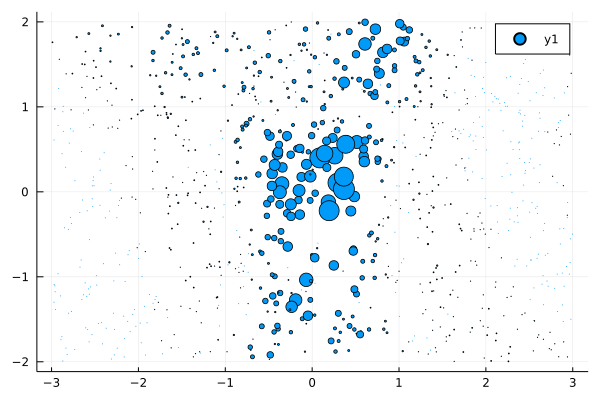

In [244]:
function koopmanerror(f, samples)
    fs = f(samples)
    diff = fs[2:end, :] .- fs[[1], :]
    mean(diff, dims=1)
end

e = koopmanerror(nn, data)
scatter(data[1,1,:], data[2,1,:], msize=abs.(e)'*100)

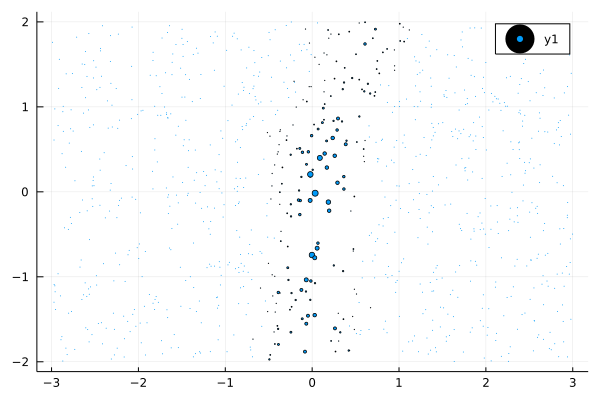

In [245]:
function koopmanvariance(f, samples)
    fs = f(samples)
    diff = fs[2:end, :] .- fs[[1], :]
    mean(diff.^2, dims=1)
end

v = koopmanvariance(nn, data)

scatter(data[1,1,:], data[2,1,:], msize=v'*100)